In [2]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../')

import numpy as np
import torch
import matplotlib.pyplot as plt

from drawing import draw_window
from image import get_image_tensor, get_numpy_image
from shape import Window, Position
from roi_align import RoIAlignFeatureExtractor, CenterFeatureExtractor, RoIFeatureExtractor
from matcher import Window
from image import load_image, rotate_image
from feature_extractor import CNN, FeatureExtractor
from candidates import Candidates
from scorer import CosineSimilarityScorer
import cv2
import albumentations as A
import os
from PIL import Image
from IPython.display import Image as IpyImage

def create_gif(images, output_path, duration=200):
    pil_images = [Image.fromarray(image) for image in images]
    pil_images[0].save(output_path, save_all=True, append_images=pil_images[1:],
                       optimize=False, duration=duration, loop=0)
    


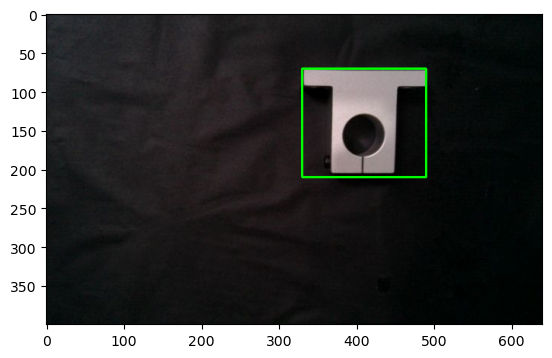

In [3]:
template_img = load_image('../data/template_1.jpg')
template_window = Window(410., 140., 160., 140., 0)

draw_img = draw_window(template_img, template_window)
plt.imshow(draw_img)

In [4]:
from feature_extractor import ReCNN
from shape.basic import Point
import torch.nn.functional as F

def test_rotation_equivalence(feature_extractor: FeatureExtractor, roi_feature_extractor: RoIFeatureExtractor):
    scales = [2, 4, 8, 16]

    img_h, img_w = template_img.shape[:2]
    rotation_center = Point((img_w - 1) * 0.5, (img_h - 1) * 0.5)
    all_rotated_images = []
    all_rotated_features = {s:[] for s in scales}

    for i in range(0, 360, 5):
        rotated_img = rotate_image(template_img.copy(), i)
        rotated_window = template_window.rotate(rotation_center, i)
        draw_img = draw_window(rotated_img, rotated_window)
        all_rotated_images.append(draw_img)

        for idx, scale in enumerate(scales):
            rotated_feature_map = feature_extractor(rotated_img)[idx]
            rotated_features = roi_feature_extractor.extract(rotated_feature_map, rotated_window, spatial_scale=1.0/scale)
            all_rotated_features[scale].append(rotated_features)


    all_rotated_features = {s:torch.cat(f) for s, f in all_rotated_features.items()}

    for scale, features in all_rotated_features.items():
        normalized_features = F.normalize(features, dim=1)
        scores = torch.matmul(normalized_features, normalized_features.T)
        print(f'max score: {scores.max().item():.3f} min score: {scores.min().item():.3f} avg score: {scores.mean().item():.3f}')
        plt.imshow(scores, cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title(f'Rotation equivalence at scale {scale}')
        plt.show()

max score: 1.000 min score: 0.946 avg score: 0.984


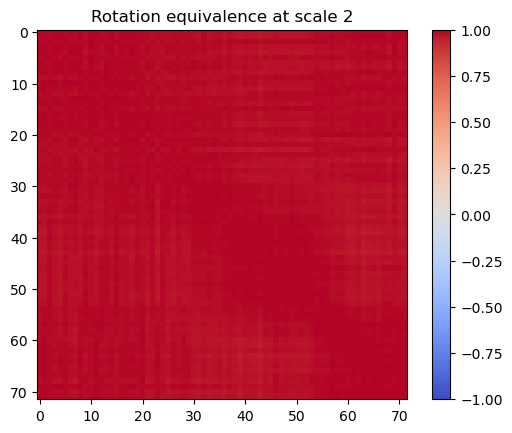

max score: 1.000 min score: -0.017 avg score: 0.682


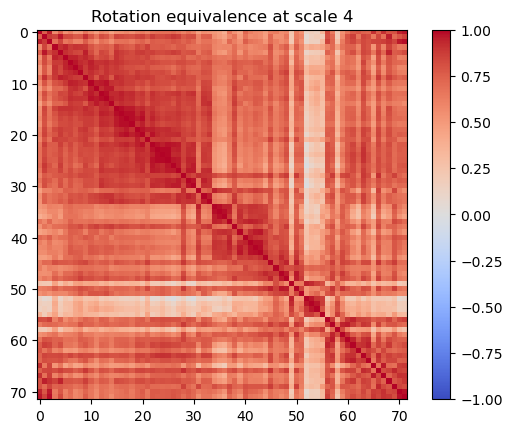

max score: 1.000 min score: -0.126 avg score: 0.595


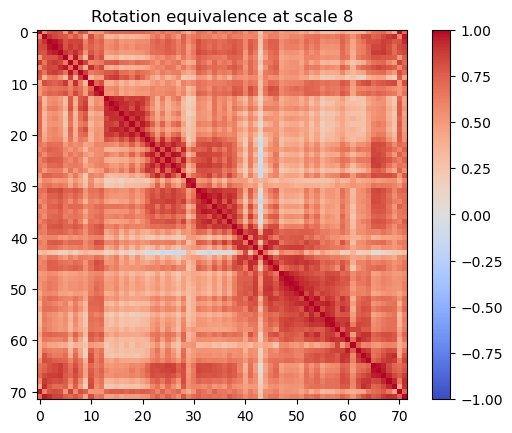

max score: 1.000 min score: -0.047 avg score: 0.489


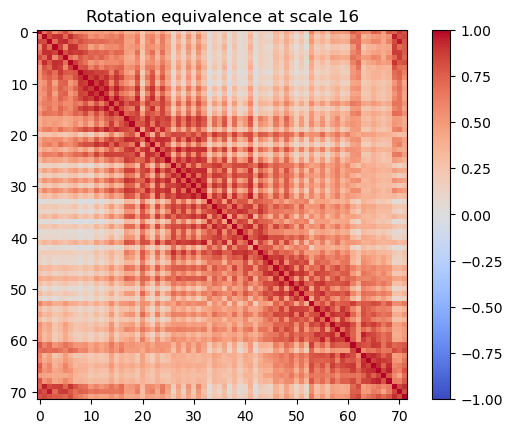

In [5]:
feature_extractor = CNN()
# feature_extractor = ReCNN()
roi_feature_extractor = CenterFeatureExtractor()
# roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2)
test_rotation_equivalence(feature_extractor, roi_feature_extractor)

In [6]:
# feature_extractor = CNN()
feature_extractor = ReCNN()
roi_feature_extractor = CenterFeatureExtractor()
# roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2)
test_rotation_equivalence(feature_extractor, roi_feature_extractor)

NameError: name 'build_resnet50' is not defined

max score: 1.000 min score: 0.041 avg score: 0.541


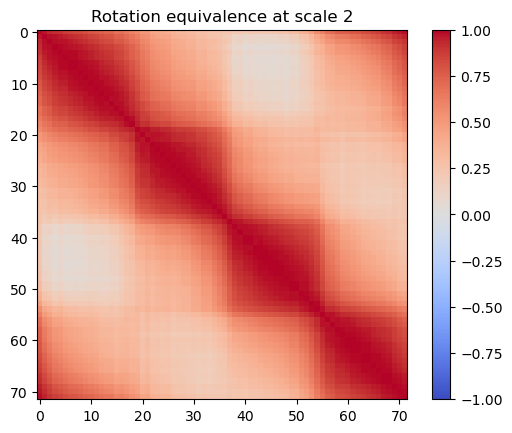

max score: 1.000 min score: 0.315 avg score: 0.635


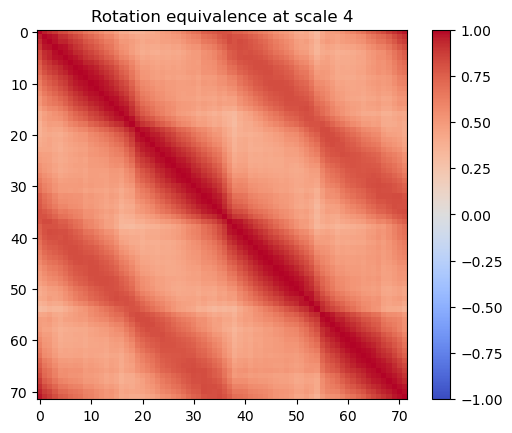

max score: 1.000 min score: 0.415 avg score: 0.619


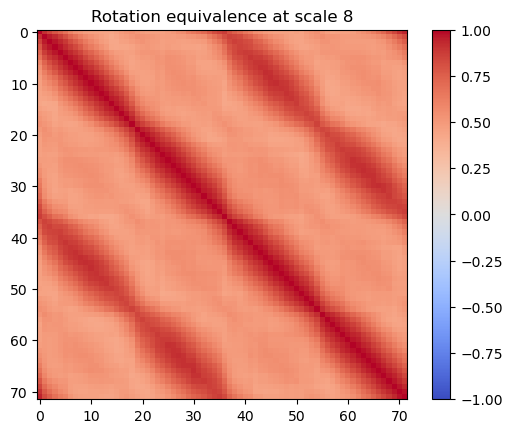

max score: 1.000 min score: 0.498 avg score: 0.697


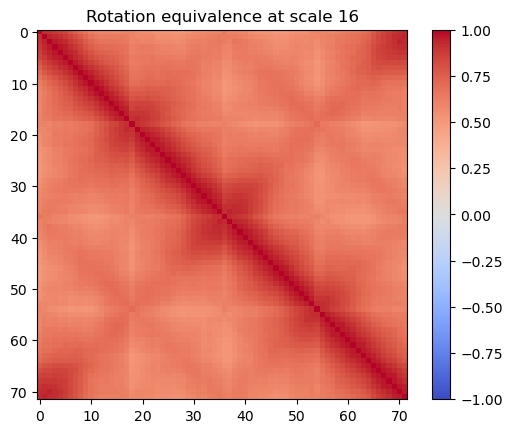

In [ ]:
feature_extractor = CNN()
# feature_extractor = ReCNN()
# roi_feature_extractor = CenterFeatureExtractor()
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2)
test_rotation_equivalence(feature_extractor, roi_feature_extractor)

max score: 1.000 min score: 0.872 avg score: 0.939


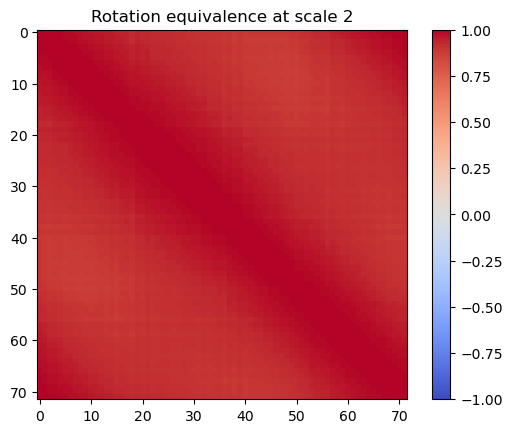

max score: 1.000 min score: 0.458 avg score: 0.662


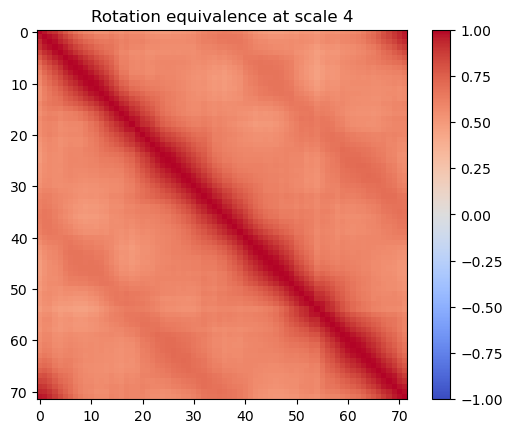

max score: 1.000 min score: 0.890 avg score: 0.925


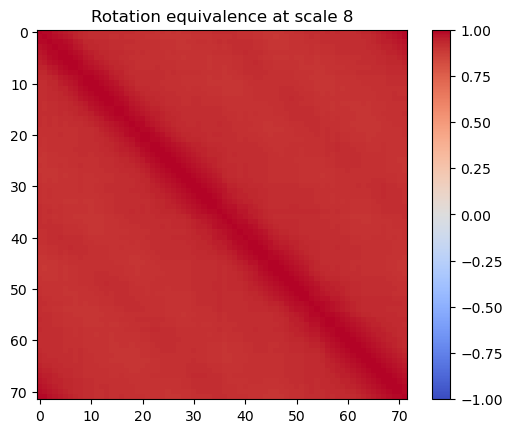

max score: 1.000 min score: 0.991 avg score: 0.997


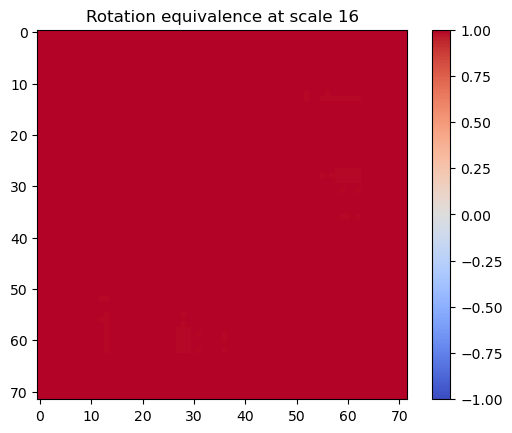

In [ ]:
# feature_extractor = CNN()
feature_extractor = ReCNN()
# roi_feature_extractor = CenterFeatureExtractor()
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2)
test_rotation_equivalence(feature_extractor, roi_feature_extractor)

In [ ]:
img_h, img_w = template_img.shape[:2]
rotation_center = Point((img_w - 1) * 0.5, (img_h - 1) * 0.5)
all_rotated_images = []
for i in range(0, 360, 5):
    rotated_img = rotate_image(template_img.copy(), i)
    rotated_window = template_window.rotate(rotation_center, i)
    draw_img = draw_window(rotated_img, rotated_window)
    all_rotated_images.append(draw_img)
    
save_path = '../data/rotated_image.gif'
if os.path.exists(save_path):
    os.remove(save_path)
create_gif(all_rotated_images, save_path)
IpyImage(url=save_path)

# Rotate 180 only window

In [ ]:
from copy import copy
rotated_window = copy(template_window)
rotated_window.angle = 180

In [ ]:
feature_extractor = CNN()
scorer = CosineSimilarityScorer()
template_feature_maps = feature_extractor(template_img)

scales = [2, 4, 8, 16]
for idx, scale in enumerate(scales):
    template_roi_features = roi_feature_extractor.extract(template_feature_maps[idx], template_window, spatial_scale=1.0/scales[idx])
    empty_roi_features = roi_feature_extractor.extract(template_feature_maps[idx], rotated_window, spatial_scale=1.0/scales[idx])
    score = scorer.score(template_roi_features, empty_roi_features)
    print(f'scale: {scale} score: {score.item():.3f}')

scale: 2 score: -0.208
scale: 4 score: 0.686
scale: 8 score: 0.672
scale: 16 score: 0.496


In [ ]:
feature_extractor = ReCNN()
scorer = CosineSimilarityScorer()
template_feature_maps = feature_extractor(template_img)

scales = [2, 4, 8, 16]
for idx, scale in enumerate(scales):
    template_roi_features = roi_feature_extractor.extract(template_feature_maps[idx], template_window, spatial_scale=1.0/scales[idx])
    empty_roi_features = roi_feature_extractor.extract(template_feature_maps[idx], rotated_window, spatial_scale=1.0/scales[idx])
    score = scorer.score(template_roi_features, empty_roi_features)
    print(f'scale: {scale} score: {score.item():.3f}')

scale: 2 score: 0.878
scale: 4 score: 0.611
scale: 8 score: 0.865
scale: 16 score: 0.979


# Compare GT and empty window

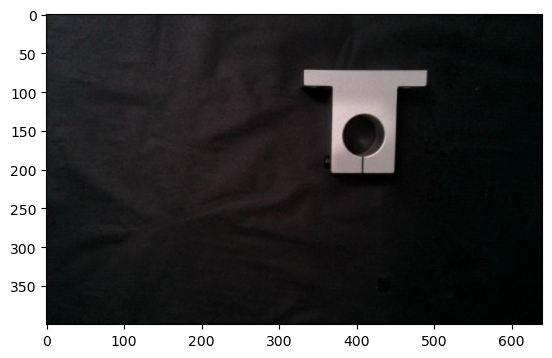

In [ ]:
plt.imshow(template_img)

In [ ]:
feature_extractor = ReCNN()
scorer = CosineSimilarityScorer()
template_feature_maps = feature_extractor(template_img)

empty_window = Window(210, 160, 160, 140, -120)

scales = [2, 4, 8, 16]
for idx, scale in enumerate(scales):
    template_roi_features = roi_feature_extractor.extract(template_feature_maps[idx], template_window, spatial_scale=1.0/scales[idx])
    empty_roi_features = roi_feature_extractor.extract(template_feature_maps[idx], empty_window, spatial_scale=1.0/scales[idx])
    score = scorer.score(template_roi_features, empty_roi_features)
    print(f'scale: {scale} score: {score.item():.3f}')

scale: 2 score: 0.936
scale: 4 score: 0.468
scale: 8 score: 0.806
scale: 16 score: 0.967


In [ ]:
feature_extractor = CNN()
scorer = CosineSimilarityScorer()
template_feature_maps = feature_extractor(template_img)

empty_window = Window(210, 160, 160, 140, -120)

scales = [2, 4, 8, 16]
for idx, scale in enumerate(scales):
    template_roi_features = roi_feature_extractor.extract(template_feature_maps[idx], template_window, spatial_scale=1.0/scales[idx])
    empty_roi_features = roi_feature_extractor.extract(template_feature_maps[idx], empty_window, spatial_scale=1.0/scales[idx])
    score = scorer.score(template_roi_features, empty_roi_features)
    print(f'scale: {scale} score: {score.item():.3f}')

scale: 2 score: 0.365
scale: 4 score: 0.394
scale: 8 score: 0.313
scale: 16 score: 0.075
